# MTCNN

## Imports

In [1]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.0 MB/s eta 0:00:00


In [2]:
from mtcnn import MTCNN
from google.colab import files
from mtcnn import MTCNN
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import io
import matplotlib.pyplot as plt

## Usage

In [9]:
def detectar_faces_mtcnn(
    mostrar_visualizacao=True,
    mostrar_estatisticas=True,
    proporcao_landmark=0.04,  # 4% do tamanho da face
    proporcao_box=0.02,        # 2% para espessura do box
    proporcao_fonte=0.15       # 15% para tamanho da fonte
):

    # ===== UPLOAD DA IMAGEM =====
    print("📤 Faça upload da imagem:")
    uploaded = files.upload()

    if not uploaded:
        print("❌ Nenhuma imagem foi enviada!")
        return None

    filename = list(uploaded.keys())[0]
    print(f"\n✅ Arquivo recebido: {filename}")

    # ===== CARREGAR IMAGEM =====
    image = Image.open(io.BytesIO(uploaded[filename]))

    if image.mode != 'RGB':
        print(f"⚠️  Convertendo de {image.mode} para RGB")
        image = image.convert('RGB')

    image_array = np.array(image)
    print(f"📐 Dimensões: {image_array.shape}")

    # ===== DETECÇÃO COM MTCNN =====
    print("\n🔍 Detectando faces com MTCNN...")
    detector = MTCNN(device="CPU:0")
    result = detector.detect_faces(image_array)

    print(f"✅ Detecção concluída: {len(result)} face(s) encontrada(s)")

    # ===== DESENHAR ANOTAÇÕES =====
    image_pil = Image.fromarray(image_array)
    draw = ImageDraw.Draw(image_pil)

    # Processar cada face detectada
    for idx, face in enumerate(result, 1):
        x, y, w, h = face['box']
        confidence = face['confidence']

        # ===== CALCULAR TAMANHOS PROPORCIONAIS =====
        # Usar a média entre largura e altura da face como referência
        face_size = (w + h) / 2

        # Tamanho do landmark proporcional à face
        radius_landmark = max(3, int(face_size * proporcao_landmark))

        # Espessura do box proporcional à face
        espessura_box = max(2, int(face_size * proporcao_box))

        # Tamanho da fonte proporcional à face
        tamanho_fonte = max(12, int(face_size * proporcao_fonte))

        # Carregar fonte com tamanho proporcional
        try:
            font = ImageFont.truetype(
                "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
                tamanho_fonte
            )
        except:
            font = ImageFont.load_default()

        # ===== BOUNDING BOX =====
        if confidence > 0.95:
            box_color = 'green'
        elif confidence > 0.85:
            box_color = 'yellow'
        else:
            box_color = 'red'

        draw.rectangle([x, y, x+w, y+h], outline=box_color, width=espessura_box)

        # ===== TEXTO DE CONFIANÇA =====
        confidence_text = f'Face {idx}: {confidence:.2%}'

        # Offset do texto proporcional ao tamanho da face
        text_offset = int(face_size * 0.15)

        text_bbox = draw.textbbox((x, y - text_offset), confidence_text, font=font)
        draw.rectangle(text_bbox, fill='black')
        draw.text((x, y - text_offset), confidence_text, fill='white', font=font)

        # ===== LANDMARKS (PROPORCIONAIS!) =====
        for key, point in face['keypoints'].items():
            # Borda proporcional (30% do raio)
            borda = max(1, int(radius_landmark * 0.3))

            # Desenhar círculo com tamanho proporcional
            draw.ellipse([point[0]-radius_landmark, point[1]-radius_landmark,
                         point[0]+radius_landmark, point[1]+radius_landmark],
                         fill='red',
                         outline='white',
                         width=borda)

        # Debug info (opcional)
        print(f"\n🔧 Face {idx} - Tamanhos calculados:")
        print(f"   Tamanho da face: {face_size:.1f} pixels")
        print(f"   Raio landmark: {radius_landmark} pixels")
        print(f"   Espessura box: {espessura_box} pixels")
        print(f"   Tamanho fonte: {tamanho_fonte}")

    # ===== VISUALIZAÇÃO =====
    if mostrar_visualizacao:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        ax1.imshow(image_array)
        ax1.set_title('ANTES - Imagem Original', fontsize=18, fontweight='bold')
        ax1.axis('off')

        ax2.imshow(image_pil)
        ax2.set_title(f'DEPOIS - {len(result)} face(s) detectada(s)',
                      fontsize=18, fontweight='bold')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

    # ===== ESTATÍSTICAS =====
    if mostrar_estatisticas:
        print("\n" + "="*60)
        print("📊 DETALHES DAS DETECÇÕES")
        print("="*60)

        if len(result) > 0:
            for idx, face in enumerate(result, 1):
                conf = face['confidence']
                x, y, w, h = face['box']
                face_size = (w + h) / 2

                print(f"\n🧑 Face {idx}:")
                print(f"   Confiança: {conf:.4f} ({conf*100:.2f}%)")
                print(f"   Bounding Box: [x={x}, y={y}, w={w}, h={h}]")
                print(f"   Tamanho médio: {face_size:.1f} pixels")
                print(f"   Área: {w * h:,} pixels²")
                print(f"   Landmarks: {list(face['keypoints'].keys())}")

            # Resumo geral
            confidences = [f['confidence'] for f in result]
            face_sizes = [(f['box'][2] + f['box'][3]) / 2 for f in result]

            print(f"\n{'─'*60}")
            print(f"📈 RESUMO:")
            print(f"   Total de faces: {len(result)}")
            print(f"   Confiança média: {np.mean(confidences):.4f} ({np.mean(confidences)*100:.2f}%)")
        else:
            print("\n⚠️ Nenhuma face foi detectada na imagem!")

        print("="*60)

    return result

📤 Faça upload da imagem:


Saving RyanGosling.jpg to RyanGosling (2).jpg

✅ Arquivo recebido: RyanGosling (2).jpg
📐 Dimensões: (1265, 1000, 3)

🔍 Detectando faces com MTCNN...
✅ Detecção concluída: 1 face(s) encontrada(s)

🔧 Face 1 - Tamanhos calculados:
   Tamanho da face: 506.0 pixels
   Raio landmark: 20 pixels
   Espessura box: 10 pixels
   Tamanho fonte: 75


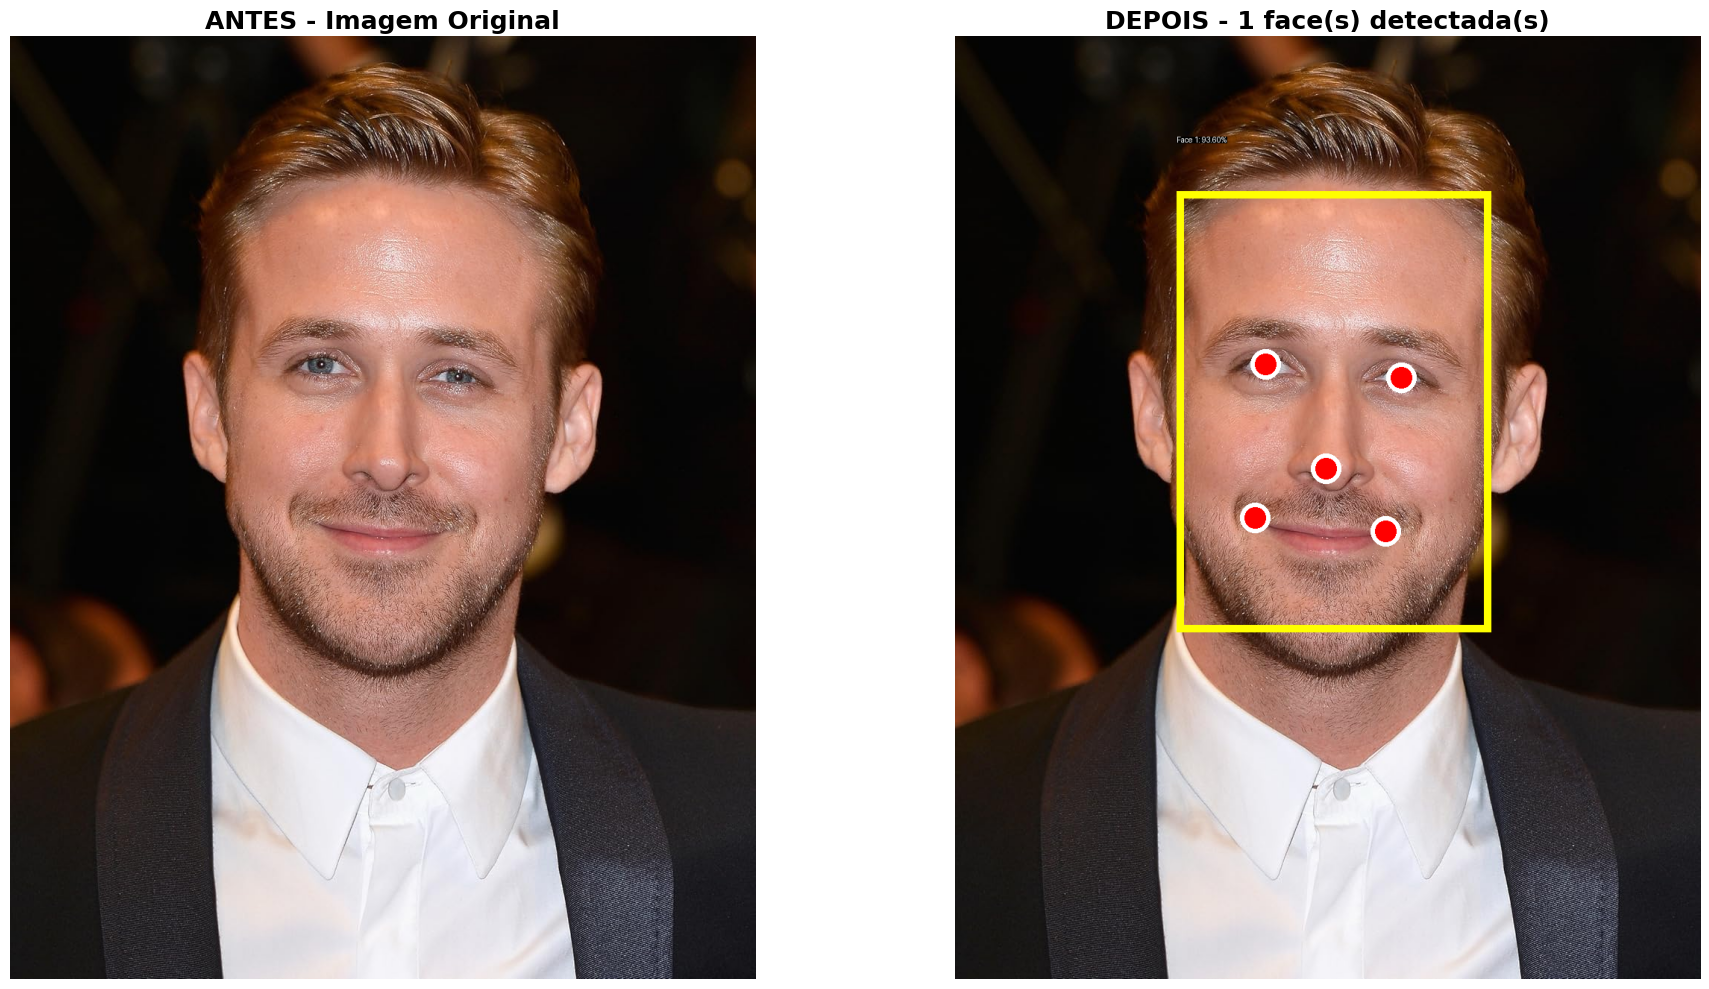


📊 DETALHES DAS DETECÇÕES

🧑 Face 1:
   Confiança: 0.9360 (93.60%)
   Bounding Box: [x=297, y=208, w=421, h=591]
   Tamanho médio: 506.0 pixels
   Área: 248,811 pixels²
   Landmarks: ['nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left']

────────────────────────────────────────────────────────────
📈 RESUMO:
   Total de faces: 1
   Confiança média: 0.9360 (93.60%)


In [10]:
resultado = detectar_faces_mtcnn()

📤 Faça upload da imagem:


Saving Cast.jpeg to Cast (2).jpeg

✅ Arquivo recebido: Cast (2).jpeg
📐 Dimensões: (675, 1200, 3)

🔍 Detectando faces com MTCNN...
✅ Detecção concluída: 7 face(s) encontrada(s)

🔧 Face 1 - Tamanhos calculados:
   Tamanho da face: 71.0 pixels
   Raio landmark: 3 pixels
   Espessura box: 2 pixels
   Tamanho fonte: 12

🔧 Face 2 - Tamanhos calculados:
   Tamanho da face: 74.0 pixels
   Raio landmark: 3 pixels
   Espessura box: 2 pixels
   Tamanho fonte: 12

🔧 Face 3 - Tamanhos calculados:
   Tamanho da face: 61.5 pixels
   Raio landmark: 3 pixels
   Espessura box: 2 pixels
   Tamanho fonte: 12

🔧 Face 4 - Tamanhos calculados:
   Tamanho da face: 70.0 pixels
   Raio landmark: 3 pixels
   Espessura box: 2 pixels
   Tamanho fonte: 12

🔧 Face 5 - Tamanhos calculados:
   Tamanho da face: 66.5 pixels
   Raio landmark: 3 pixels
   Espessura box: 2 pixels
   Tamanho fonte: 12

🔧 Face 6 - Tamanhos calculados:
   Tamanho da face: 67.5 pixels
   Raio landmark: 3 pixels
   Espessura box: 2 pixels
   Ta

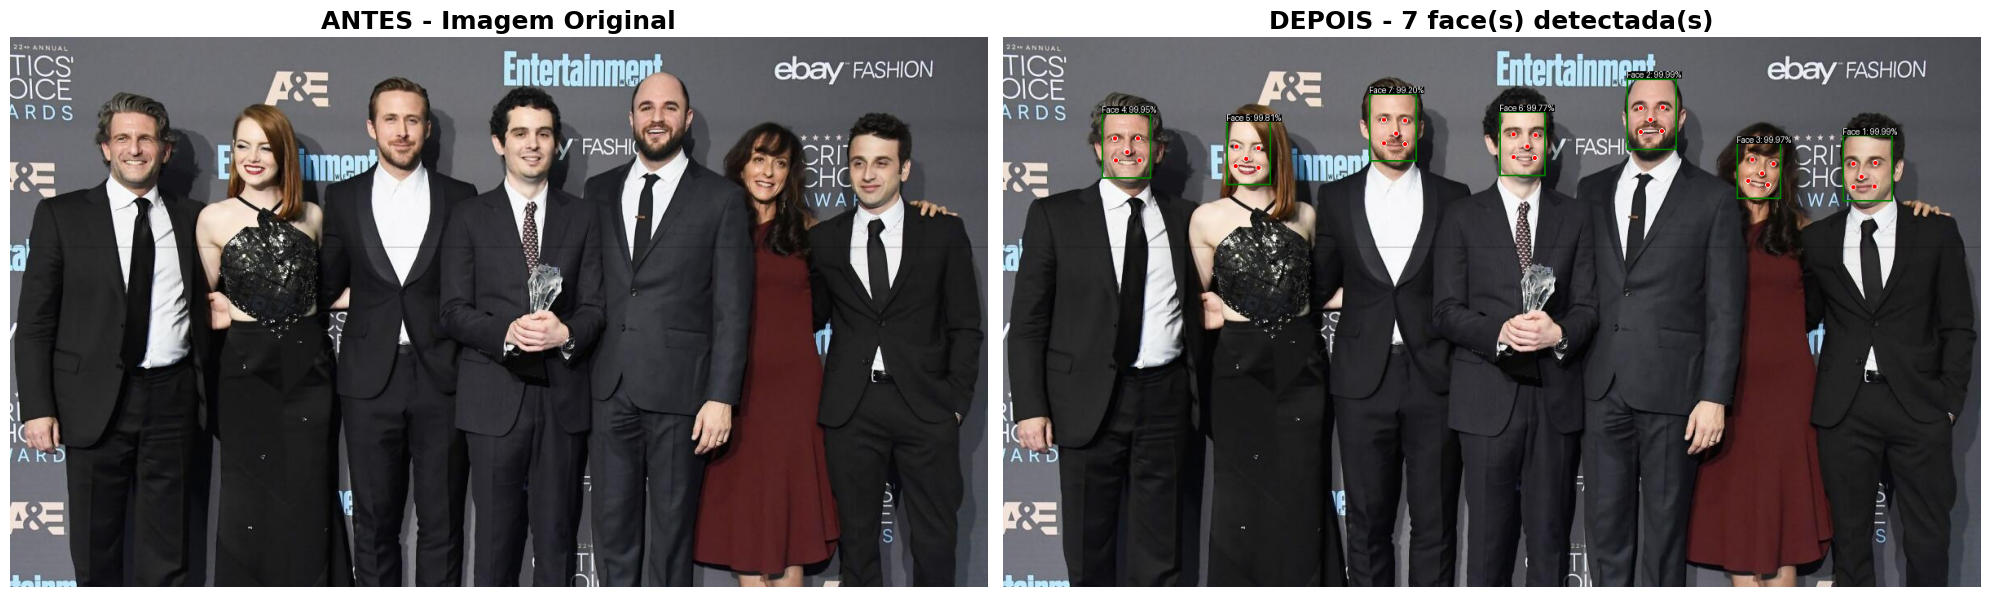


📊 DETALHES DAS DETECÇÕES

🧑 Face 1:
   Confiança: 0.9999 (99.99%)
   Bounding Box: [x=1030, y=120, w=61, h=81]
   Tamanho médio: 71.0 pixels
   Área: 4,941 pixels²
   Landmarks: ['nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left']

🧑 Face 2:
   Confiança: 0.9999 (99.99%)
   Bounding Box: [x=765, y=51, w=61, h=87]
   Tamanho médio: 74.0 pixels
   Área: 5,307 pixels²
   Landmarks: ['nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left']

🧑 Face 3:
   Confiança: 0.9997 (99.97%)
   Bounding Box: [x=900, y=129, w=54, h=69]
   Tamanho médio: 61.5 pixels
   Área: 3,726 pixels²
   Landmarks: ['nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left']

🧑 Face 4:
   Confiança: 0.9995 (99.95%)
   Bounding Box: [x=121, y=93, w=60, h=80]
   Tamanho médio: 70.0 pixels
   Área: 4,800 pixels²
   Landmarks: ['nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left']

🧑 Face 5:
   Confiança: 0.9981 (99.81%)
   Bounding Box: [x=274, y=102, w=54, h=79]
   Tamanho médio: 66.5 pixels


In [11]:
resultado = detectar_faces_mtcnn()

📤 Faça upload da imagem:


Saving Chefao.jpg to Chefao.jpg

✅ Arquivo recebido: Chefao.jpg
📐 Dimensões: (900, 647, 3)

🔍 Detectando faces com MTCNN...
✅ Detecção concluída: 1 face(s) encontrada(s)

🔧 Face 1 - Tamanhos calculados:
   Tamanho da face: 154.5 pixels
   Raio landmark: 6 pixels
   Espessura box: 3 pixels
   Tamanho fonte: 23


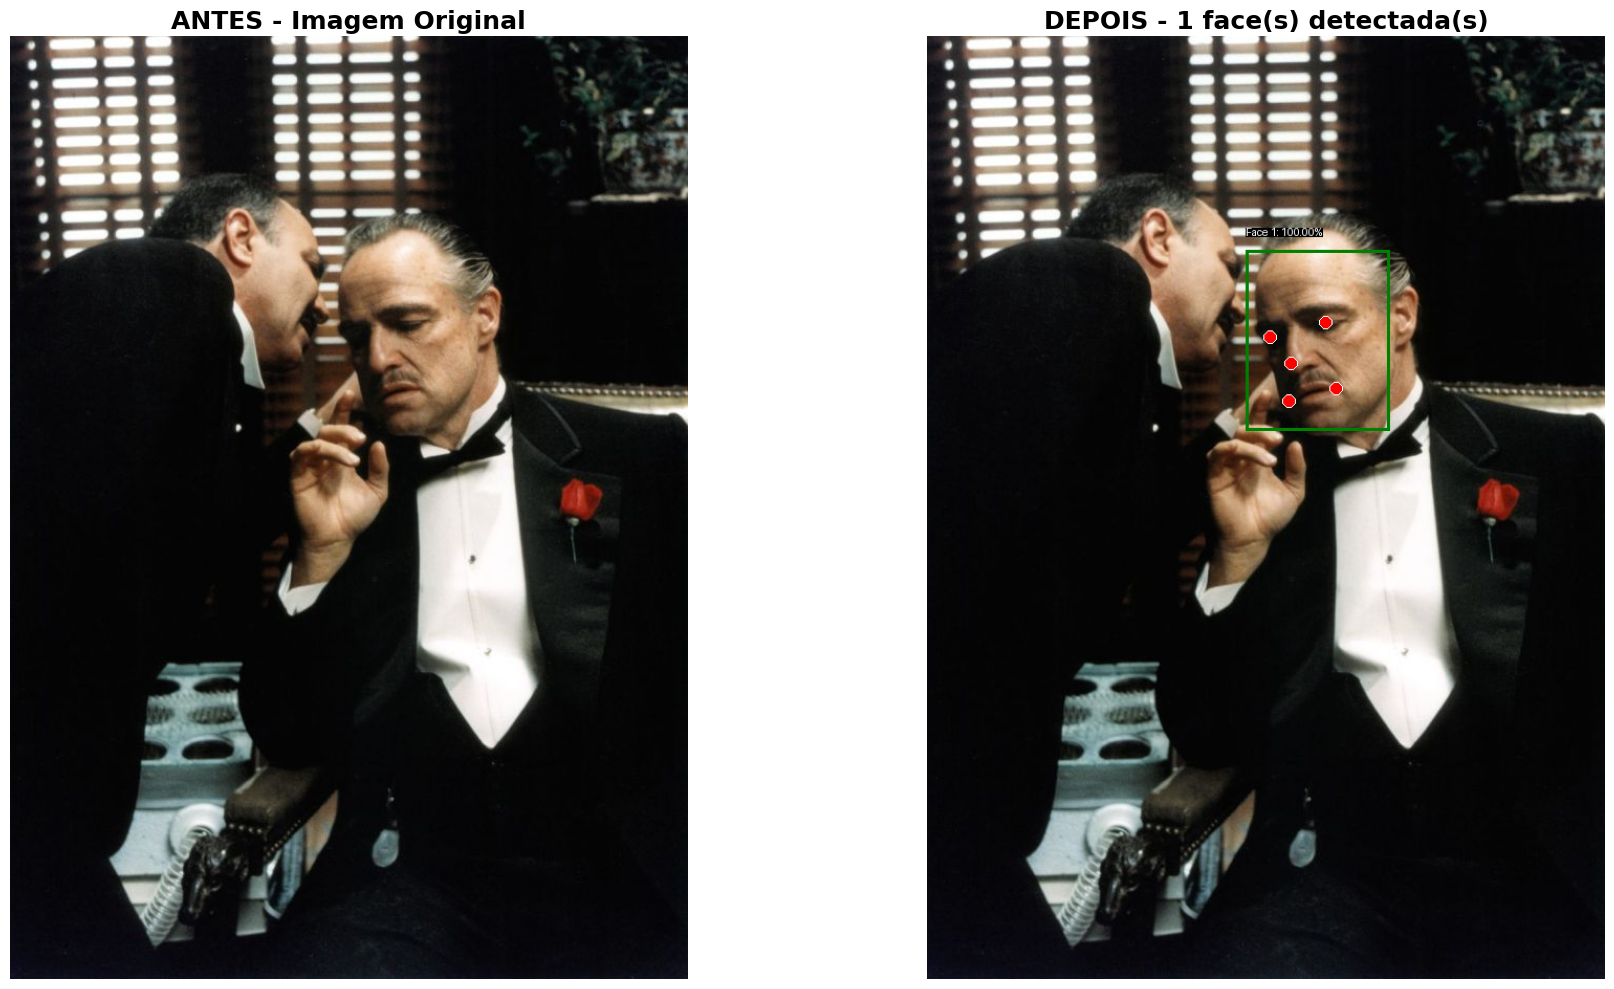


📊 DETALHES DAS DETECÇÕES

🧑 Face 1:
   Confiança: 1.0000 (100.00%)
   Bounding Box: [x=304, y=204, w=137, h=172]
   Tamanho médio: 154.5 pixels
   Área: 23,564 pixels²
   Landmarks: ['nose', 'mouth_right', 'right_eye', 'left_eye', 'mouth_left']

────────────────────────────────────────────────────────────
📈 RESUMO:
   Total de faces: 1
   Confiança média: 1.0000 (100.00%)


In [12]:
resultado = detectar_faces_mtcnn()